# Problem 2: Implementing a Multi-layer Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from zipfile import ZipFile, Path
import os

In [2]:
def sigmoid_forward(a):
    # calculates the sigmoid activation function
    # a: pre-activation values
    # returns: activated values
    return 1 / (1 + np.exp(-a))
    

def sigmoid_backward(grad_accum, a):
    # grad_accum: the gradient of the loss function w.r.t to z
    # a: the pre-activation values
    # returns: the gradient of the loss w.r.t to the preactivation values, a
    der_sigmoid = sigmoid_forward(a) * (1-sigmoid_forward(a))
    
    
    gradient = der_sigmoid * grad_accum
    return gradient

def linear_forward(x, weight, bias):
    # Computes the forward pass of the linear layer
    # x: input of layer
    # weight, bias: weights and bias of neural network layer
    # returns: output of linear layer
    
    new_weights = np.concatenate((bias.reshape((bias.shape[0],1)),weight),axis=1)   #should be (785 * 256)
    new_x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
    
    output = np.dot(new_x, new_weights.T) 
#     output = np.dot(x, weight.T) + bias
    return output

def linear_backward(grad_accum, x, weight, bias):
    #  Derivative of the linear layer w.r.t 
    # grad_accum: gradient of loss w.r.t function after linear layer
    # returns dl_dw: gradient of loss w.r.t to weights 
    # returns dl_dx: gradient of loss w.r.t to input, x  
    # return dl_dw, dl_dx
    # alpha_weights = (256, 784), beta_weights = (10, 256)
    # alpha_bias = (256,), beta_bias = (10,)
    
    
    weight_bias = np.concatenate((bias.reshape((bias.shape[0],1)),weight),axis=1)  
    x_1 = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)            
        
    dl_dw = x_1.T @ grad_accum

    dl_dx = grad_accum @ weight_bias
    
    dl_dx = dl_dx[:,1:]
    
    
    return dl_dw, dl_dx
#     return dl_dw , dl_dx
    
def softmax_xeloss_forward(b, labels):
    # Input parameters: 
    ## b: pre-activation 
    # calculates the softmax of the vector b
    # calculates the cross entropy loss   between the softmax of b and the labels 
    # returns: l
    
    
    e = np.exp(b- np.max(b))
    sum_of_e = np.sum(e,axis=1)
    softmax_output = e/np.expand_dims(sum_of_e, 1)

    m = labels.shape[0]

    log_likelihood = -np.log(softmax_output[range(m),labels.astype('int')])
    loss = np.sum(log_likelihood) / m

    return loss
    
    
def softmax_xeloss_backward(yhat, labels):
    # Input parameters:
    # yhat: predictions of the neural network
    # labels: target of the network
    # returns: dl_db gradient of loss w.r.t to b
    
    m = labels.shape[0]
    yhat[range(m),labels.astype('int')] -= 1
    dl_db = yhat/m
    
    return dl_db
    
def data_load():
    # load in the data provided in "data/"
    # Unzip fashion_mnist.zip
    with ZipFile("fashion_mnist.zip") as myzip:
        data_train = myzip.open("train.csv")
        data_test = myzip.open("test.csv")
    train_df = pd.read_csv(data_train,header  = None)
    test_df = pd.read_csv(data_test,header  = None)
    
    X_train = train_df.iloc[: , :-1]
    y_train = train_df.iloc[: , -1]
    X_test = test_df.iloc[: , :-1]
    y_test = test_df.iloc[: , -1]

    return X_train, y_train, X_test, y_test

def load_params():
    alpha_weights = np.loadtxt('params/alpha1.txt', delimiter=',')
    beta_weights = np.loadtxt('params/alpha2.txt', delimiter=',')
    alpha_bias= np.loadtxt('params/beta1.txt', delimiter=',')
    beta_bias = np.loadtxt('params/beta2.txt', delimiter=',')
    return alpha_weights, beta_weights, alpha_bias, beta_bias

def one_hot_encode(y):
    # convert categorical target features to one hot encoded data
    rows, cols = (len(y), y.nunique())
    class_arr = [[0 for i in range(cols)] for j in range(rows)]
    class_arr = np.array(class_arr)
#     print(class_arr.shape)
    for index,value in y.iteritems():
        class_arr[index][int(value)] = 1
#     df = pd.DataFrame(arr) 
    return class_arr



def train(batchsize=1 , eta = 0.01, num_epochs=100, h = 256, init='default'):
    X_train, y_train, X_test, y_test = data_load()  
    
#     y_train = one_hot_encode(y_train) 
#     y_test = one_hot_encode(y_test) 

    if init == 'default':
       alpha_weights, beta_weights, alpha_bias, beta_bias = load_params()
    elif init=='zeros':
        # initialize weights and biases to 0
        alpha_weights, beta_weights = np.zeros((256, 784)), np.zeros((10, 256))
        alpha_bias, beta_bias = np.zeros((256,)), np.zeros((10,))
#         pass
    elif init=='ones':
        # initialize weights and biases to 1
        alpha_weights, beta_weights = np.ones((256, 784)), np.ones((10, 256))
        alpha_bias, beta_bias = np.ones((256,)), np.ones((10,))
#         pass
    elif init=='random':
        # initialize weights and biases to random values between -1 and 1
        alpha_weights, beta_weights = np.random.uniform(low=-1, high=1, size=(256, 784)),np.random.uniform(low=-1, high=1, size=(10, 256))
        alpha_bias, beta_bias = np.random.uniform(low=-1, high=1, size=(256,)), np.random.uniform(low=-1, high=1, size=(10,))
#         pass
        
    train_loss_list = []
    test_loss_list = []
    acc_list = []
    
    

    for epoch in (range(num_epochs)):
#         continue
#         print('# epoch:', epoch + 1) 
        epoch_loss_lst = []
        # Iterate over batches of data
        for pos in range(0,len(X_train),batchsize):  
            # do not shuffle data
            # select batch
            X_train_batch = X_train[pos:pos+batchsize]
            y_train_batch = y_train[pos:pos+batchsize]

            ######## FORWARD 
            # Linear -> Sigmoid -> Linear -> Softmax

            a = linear_forward(X_train_batch, alpha_weights, alpha_bias)
#             display(a)

            z = np.array(list(map(sigmoid_forward, a)))
#             display(z)

            b = linear_forward(z, beta_weights, beta_bias)
#             display(b)

            loss = softmax_xeloss_forward(b,y_train_batch)
            epoch_loss_lst.append(loss)
            ######## BACKWARD 
            e = np.exp(b- np.max(b))
            sum_of_e = np.sum(e,axis=1)
            softmax_output = e/np.expand_dims(sum_of_e, 1)

            dl_db = softmax_xeloss_backward(softmax_output, y_train_batch)

            dl_dB, dl_dz = linear_backward(dl_db, z, beta_weights, beta_bias)

            sig_back_gradient = sigmoid_backward(dl_dz, a)

            dl_dA, dl_dx = linear_backward(sig_back_gradient, X_train_batch, alpha_weights, alpha_bias)

            ######## UPDATE
            
            b = b - dl_db * eta
            beta_weights = beta_weights - dl_dB.T[:,1:] * eta
#             display(beta_weights)
            beta_bias = beta_bias - dl_dB.T[:,0] * eta
#             display(beta_bias)
            z = z - dl_dz * eta
            alpha_weights = alpha_weights - dl_dA.T[:,1:] * eta
#             display(alpha_weights)
            alpha_bias = alpha_bias - dl_dA.T[:,0] * eta
#             display(alpha_bias)
            a = a - sig_back_gradient * eta
            X_train_batch = X_train_batch - dl_dx * eta

        
        
        # store average training loss for the epoch
        train_loss_list.append(sum(epoch_loss_lst)/len(epoch_loss_lst))
    
        a = linear_forward(X_train, alpha_weights, alpha_bias)

        z = np.array(list(map(sigmoid_forward, a)))

        b = linear_forward(z, beta_weights, beta_bias)
        
        e = np.exp(b- np.max(b))
        sum_of_e = np.sum(e,axis=1)
        softmax_output = e/np.expand_dims(sum_of_e, 1)
    
        
        train_predict_one_hot = np.zeros_like(softmax_output)
        train_predict_one_hot[np.arange(len(softmax_output)), softmax_output.argmax(1)] = 1

        # calculate test predictions and loss
        a = linear_forward(X_test, alpha_weights, alpha_bias)

        z = np.array(list(map(sigmoid_forward, a)))

        b = linear_forward(z, beta_weights, beta_bias)

        loss = softmax_xeloss_forward(b,y_test)
        
        test_loss_list.append(loss)
        
        e = np.exp(b- np.max(b))
        sum_of_e = np.sum(e,axis=1)
        softmax_output = e/np.expand_dims(sum_of_e, 1)
    
        # calculate test accuracy
        test_predict_one_hot = np.zeros_like(softmax_output)
        test_predict_one_hot[np.arange(len(softmax_output)), softmax_output.argmax(1)] = 1
        test_one_hot = one_hot_encode(y_test)
        
        accuracy = ((test_predict_one_hot*test_one_hot).sum())/len(y_test)
        acc_list.append(accuracy)
  
#         print('===================================================================================')
        
    return train_loss_list, test_loss_list , acc_list, train_predict_one_hot, test_predict_one_hot

    


# Plot Loss 

In [3]:
# Plot training loss, testing loss as a function of epochs
train_loss_list, test_loss_list, acc_list, train_predict_one_hot, test_predict_one_hot = train(batchsize=1 , eta = 0.01, num_epochs=20, h = 256, init='default')

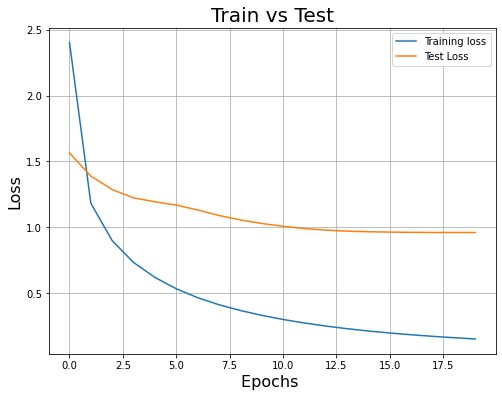

In [4]:
plt.figure(figsize=[8,6])
plt.title('Train vs Test',fontsize=20)
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(['Training loss', 'Test Loss'],fontsize=10)
plt.grid()

# Confusion Matrix

In [5]:
def plot_confusion(yhat, y, title = '[Training or Test] Set'):

    pred_train = np.argmax(yhat, axis=1)
    true_train = np.argmax(y, axis=1)
    print(true_train.shape)
    conf_train = np.zeros((10,10))
    for i in range(len(y)):
        conf_train[ true_train[i], pred_train[i] ] += int(1)
        
    sns.heatmap(conf_train, annot=True, fmt='.3g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
# plot_confusion(yhat_train, y_train, title = "Training Set")
# plot_confusion(yhat_test, y_test, title = "Test Set")
#yhat: predictions
#y: one-hot-encoded labels


(1000,)


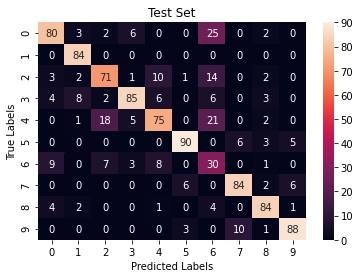

In [6]:
X_train, y_train, X_test, y_test = data_load()
plot_confusion(one_hot_encode(y_test), test_predict_one_hot, title = 'Test Set')

# Correct and Incorrect Classification Samples

In [7]:
def plot_image(vector, out_f_name, label=None):
    """
    Takes a vector as input of size (784) and saves as an image
    """
    image = np.asarray(vector).reshape(28, 28)
    plt.imshow(image, cmap='gray')
    if label:
        plt.title(label)
    plt.axis('off')
#     plt.savefig(f'{out_f_name}.png', bbox_inches='tight')
    plt.show()


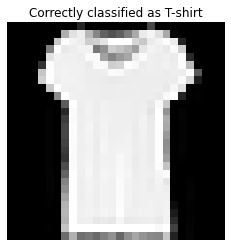

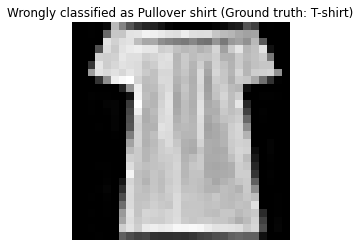

In [8]:
# Use plot_image function to display samples that are correctly and incorrectly predicted
plot_image(X_test.iloc[32],'Correctly classified', label='Correctly classified as T-shirt')
plot_image(X_test.iloc[38],'Wrongly classified', label='Wrongly classified as Pullover shirt (Ground truth: T-shirt)')

# iloc 32, 36 in X_test is labeled correctly as tshirt (class 0)
# iloc 38, 54 in X_test is labeled incorrectly as Pullover shirt (class 2)

# Effect Of Learning Rate

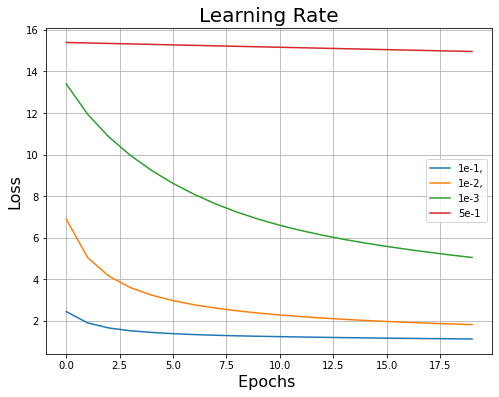

In [9]:
# Train
train_loss_list_1, test_loss_list_1, acc_list_1, train_predict_one_hot_1, test_predict_one_hot_1 = train(batchsize=50 , eta = 0.1, num_epochs=20, h = 256, init='default')
train_loss_list_2, test_loss_list_2, acc_list_2, train_predict_one_hot_2, test_predict_one_hot_2 = train(batchsize=50 , eta = 0.01, num_epochs=20, h = 256, init='default')
train_loss_list_3, test_loss_list_3, acc_list_3, train_predict_one_hot_3, test_predict_one_hot_3 = train(batchsize=50 , eta = 0.001, num_epochs=20, h = 256, init='default')
train_loss_list_5, test_loss_list_5, acc_list_5, train_predict_one_hot_5, test_predict_one_hot_5 = train(batchsize=50 , eta = 0.00001, num_epochs=20, h = 256, init='default')

# Plot test loss as a function of epochs
plt.figure(figsize=[8,6])
plt.title('Learning Rate',fontsize=20)
plt.plot(test_loss_list_1)
plt.plot(test_loss_list_2)
plt.plot(test_loss_list_3)
plt.plot(test_loss_list_5)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(['1e-1,','1e-2,','1e-3','5e-1'],fontsize=10)
plt.grid()

# Effect of Initialization

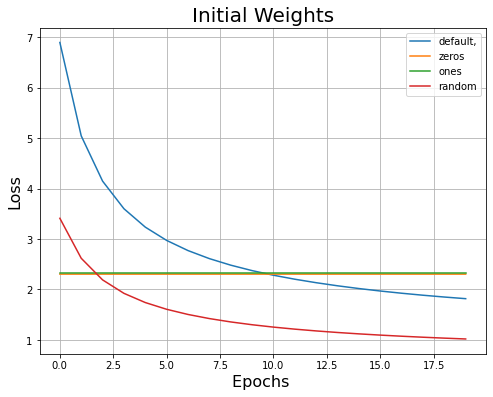

In [10]:
# Train
train_loss_list_default, test_loss_list_default, acc_list_default, train_predict_one_hot_default, test_predict_one_hot_default = train(batchsize=50 , eta=0.01, num_epochs=20, h = 256, init='default')
train_loss_list_zeros, test_loss_list_zeros, acc_list_zeros, train_predict_one_hot_zeros, test_predict_one_hot_zeros = train(batchsize=50 , eta=0.01, num_epochs=20, h = 256, init='zeros')
train_loss_list_ones, test_loss_list_ones, acc_list_ones, train_predict_one_hot_ones, test_predict_one_hot_ones = train(batchsize=50 , eta=0.01, num_epochs=20, h = 256, init='ones')
train_loss_list_random, test_loss_list_random, acc_list_random, train_predict_one_hot_random, test_predict_one_hot_random = train(batchsize=50 , eta=0.01, num_epochs=20, h = 256, init='random')

# Plot test loss as a function of epochs
plt.figure(figsize=[8,6])
plt.title('Initial Weights',fontsize=20)
plt.plot(test_loss_list_default)
plt.plot(test_loss_list_zeros)
plt.plot(test_loss_list_ones)
plt.plot(test_loss_list_random)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(['default,','zeros','ones','random'],fontsize=10)
plt.grid()

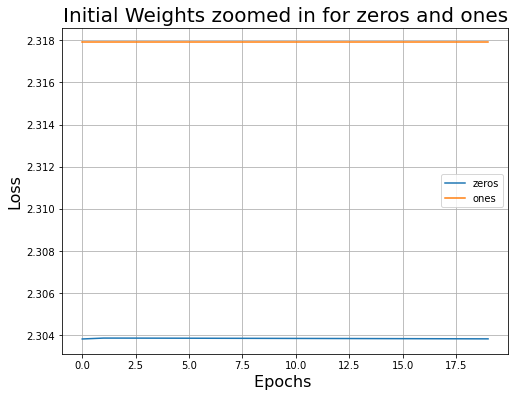

In [11]:
plt.figure(figsize=[8,6])
plt.title('Initial Weights zoomed in for zeros and ones',fontsize=20)

plt.plot(test_loss_list_zeros)
plt.plot(test_loss_list_ones)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(['zeros','ones'],fontsize=10)
plt.grid()